<a href="https://colab.research.google.com/github/MarynaMarkova/TensorFlow_Coursera/blob/main/IMDB_Reviews_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building Models for the IMDB Reviews Dataset

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Download and Prepare the Dataset

In [3]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTKH4JC/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTKH4JC/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTKH4JC/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [5]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

Plot Utility

In [6]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Model 1: Flatten

In [7]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [8]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 3s 11ms/step - loss: 0.6123 - accuracy: 0.6604 - val_loss: 0.3995 - val_accuracy: 0.8274
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.3210 - accuracy: 0.8677 - val_loss: 0.3472 - val_accuracy: 0.8478
Epoch 3/10
196/196 [==============================] - 3s 14ms/step - loss: 0.2089 - accuracy: 0.9240 - val_loss: 0.3516 - val_accuracy: 0.8502
Epoch 4/10
196/196 [==============================] - 2s 10ms/step - loss: 0.1255 - accuracy: 0.9645 - val_loss: 0.3862 - val_accuracy: 0.8422
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0618 - accuracy: 0.9904 - val_loss: 0.4349 - val_accuracy: 0.8360
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0290 - accuracy: 0.9973 - val_loss: 0.4824 - val_accuracy: 0.8338
Epoch 7/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0156 - accuracy: 0.9990 - val_loss: 0.5110 - val_accuracy: 0.8350

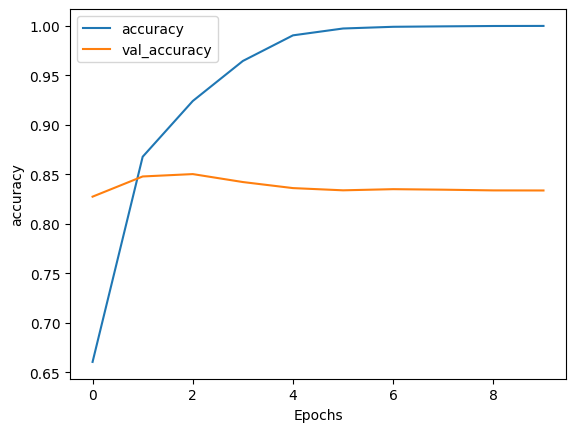

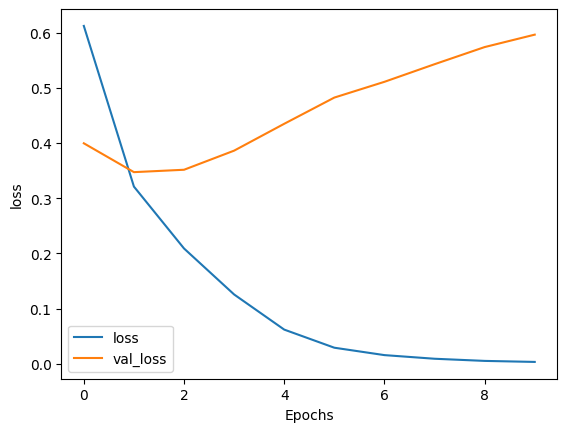

In [9]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

# LSTM

In [10]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [11]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 46s 205ms/step - loss: 0.5391 - accuracy: 0.7118 - val_loss: 0.3966 - val_accuracy: 0.8239
Epoch 2/10
196/196 [==============================] - 36s 186ms/step - loss: 0.3211 - accuracy: 0.8684 - val_loss: 0.3616 - val_accuracy: 0.8408
Epoch 3/10
196/196 [==============================] - 38s 196ms/step - loss: 0.2573 - accuracy: 0.8997 - val_loss: 0.3744 - val_accuracy: 0.8337
Epoch 4/10
196/196 [==============================] - 38s 194ms/step - loss: 0.2183 - accuracy: 0.9186 - val_loss: 0.3965 - val_accuracy: 0.8350
Epoch 5/10
196/196 [==============================] - 39s 200ms/step - loss: 0.1916 - accuracy: 0.9314 - val_loss: 0.4133 - val_accuracy: 0.8298
Epoch 6/10
196/196 [==============================] - 37s 188ms/step - loss: 0.1646 - accuracy: 0.9438 - val_loss: 0.4918 - val_accuracy: 0.8198
Epoch 7/10
196/196 [==============================] - 38s 192ms/step - loss: 0.1490 - accuracy: 0.9487 - val_loss: 0.5635 - val_ac

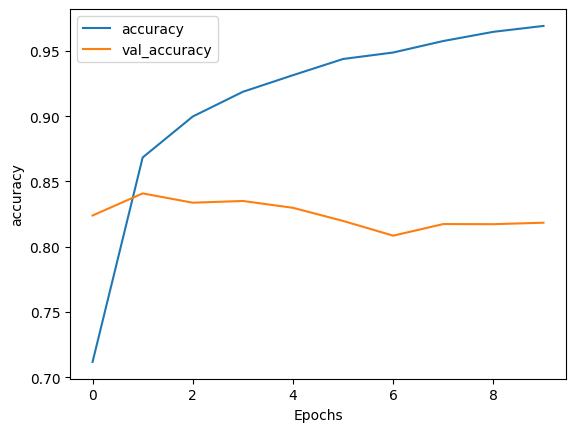

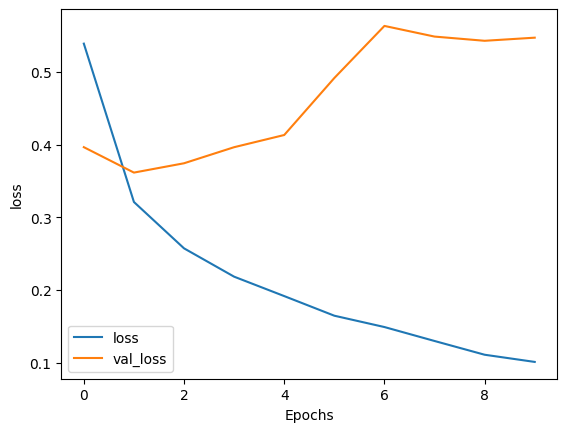

In [12]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

# GRU Gated Recurrent Unit

In [13]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [14]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 58s 252ms/step - loss: 0.5768 - accuracy: 0.6648 - val_loss: 0.3628 - val_accuracy: 0.8432
Epoch 2/10
196/196 [==============================] - 39s 198ms/step - loss: 0.3118 - accuracy: 0.8708 - val_loss: 0.3598 - val_accuracy: 0.8466
Epoch 3/10
196/196 [==============================] - 37s 190ms/step - loss: 0.2353 - accuracy: 0.9080 - val_loss: 0.4001 - val_accuracy: 0.8413
Epoch 4/10
196/196 [==============================] - 36s 183ms/step - loss: 0.1857 - accuracy: 0.9301 - val_loss: 0.4131 - val_accuracy: 0.8367
Epoch 5/10
196/196 [==============================] - 36s 183ms/step - loss: 0.1418 - accuracy: 0.9507 - val_loss: 0.4854 - val_accuracy: 0.8273
Epoch 6/10
196/196 [==============================] - 39s 198ms/step - loss: 0.1155 - accuracy: 0.9593 - val_loss: 0.5641 - val_accuracy: 0.8193
Epoch 7/10
196/196 [==============================] - 40s 207ms/step - loss: 0.0937 - accuracy: 0.9676 - val_loss: 0.6417 - val_ac

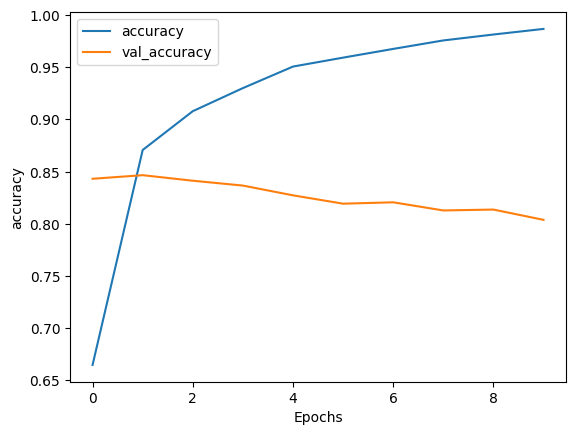

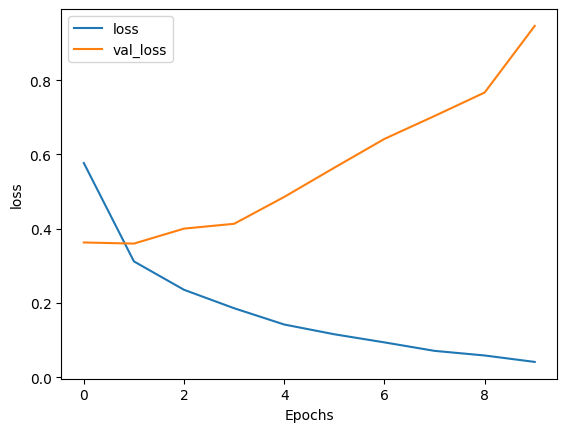

In [15]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

# Convolution

In [16]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [17]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 12s 57ms/step - loss: 0.6014 - accuracy: 0.6942 - val_loss: 0.5068 - val_accuracy: 0.8233
Epoch 2/10
196/196 [==============================] - 12s 60ms/step - loss: 0.4492 - accuracy: 0.8666 - val_loss: 0.4621 - val_accuracy: 0.8460
Epoch 3/10
196/196 [==============================] - 12s 61ms/step - loss: 0.3774 - accuracy: 0.8977 - val_loss: 0.4641 - val_accuracy: 0.8405
Epoch 4/10
196/196 [==============================] - 9s 48ms/step - loss: 0.3289 - accuracy: 0.9155 - val_loss: 0.4888 - val_accuracy: 0.8345
Epoch 5/10
196/196 [==============================] - 9s 48ms/step - loss: 0.2883 - accuracy: 0.9268 - val_loss: 0.4818 - val_accuracy: 0.8286
Epoch 6/10
196/196 [==============================] - 10s 52ms/step - loss: 0.2549 - accuracy: 0.9380 - val_loss: 0.5218 - val_accuracy: 0.8264
Epoch 7/10
196/196 [==============================] - 10s 52ms/step - loss: 0.2270 - accuracy: 0.9452 - val_loss: 0.5558 - val_accuracy: 0

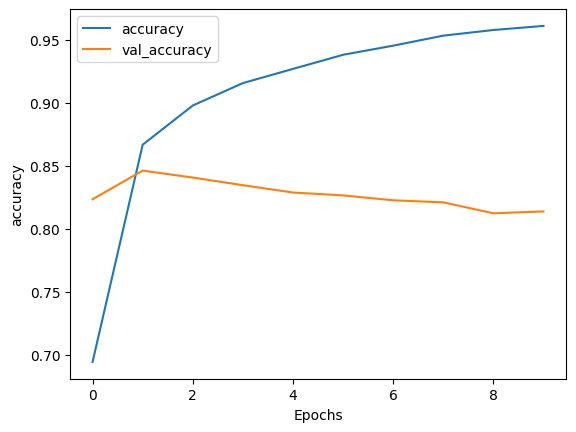

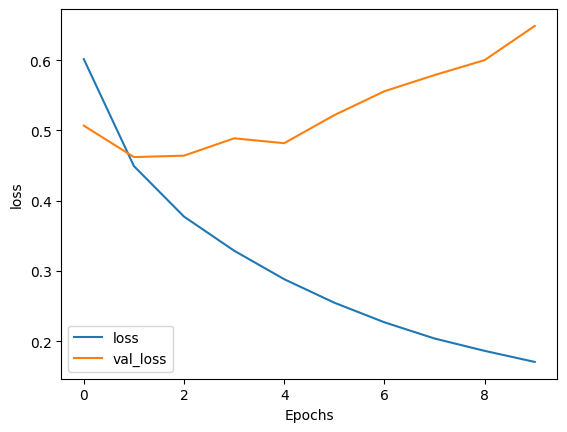

In [18]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')